In [2]:
#importing relevant packages
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import *
from sklearn import *
import lime, lime.lime_tabular


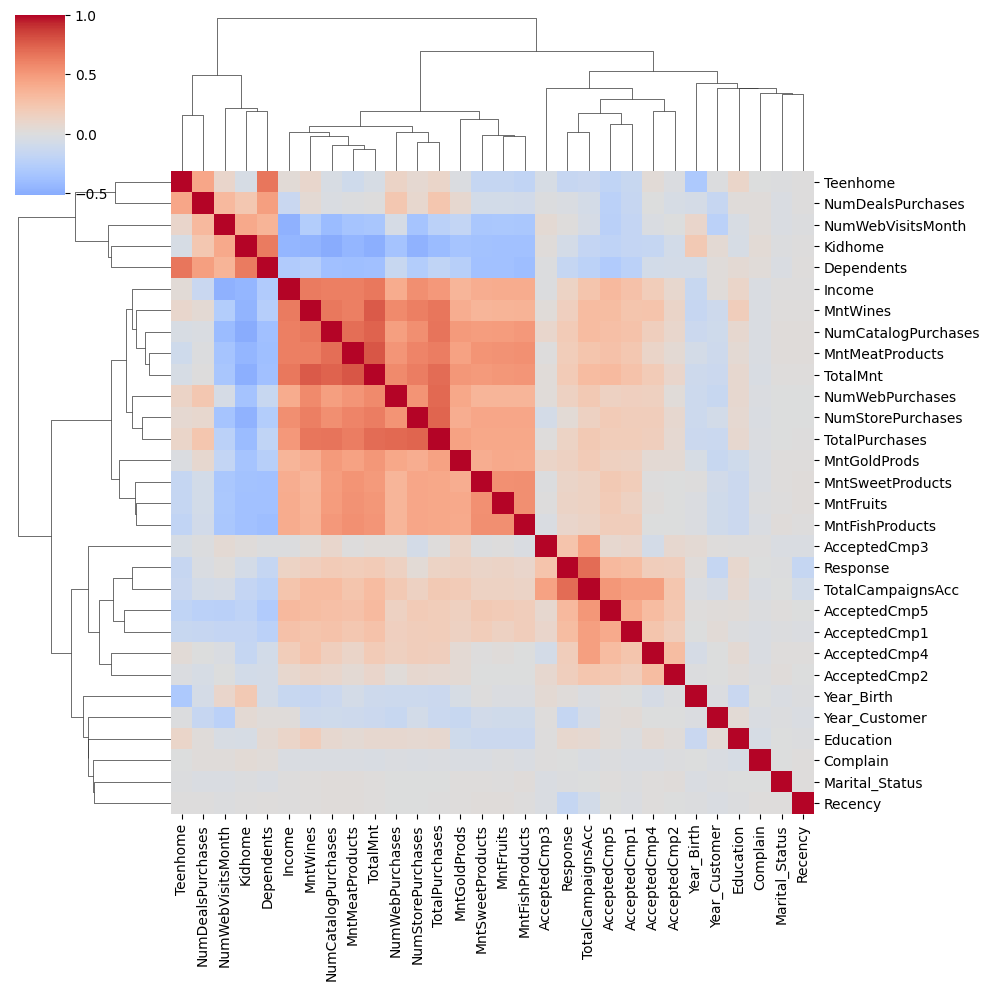

In [37]:
#getting the data and performing some transformations
ifood_origin = pd.read_csv("C:/Users/user/Desktop/Data Stuffs/Portfolio Projects/Marketing_analytics - ifood/ml_project1_data.csv")
ifood = pd.read_csv("C:/Users/user/Desktop/Data Stuffs/Portfolio Projects/Marketing_analytics - ifood/ml_project1_data.csv", parse_dates = ['Dt_Customer'])
#print(ifood.isnull().sum(axis = 0))
#print(ifood['Income'].isnull().sum() / np.prod(ifood.shape) * 100)
ifood = ifood.dropna(how = 'any')
ifood = ifood[ifood['Income'].isnull() == False]
#print(ifood.isnull().sum(axis = 0))
#print(ifood.nunique(axis = 0))
#print(ifood.dtypes)
#print(ifood.describe())
ifood['Income'] = ifood['Income'].astype('float64')
ifood['Dependents'] = ifood['Kidhome'] + ifood['Teenhome'] #good to just combine with total number of dependents
ifood['Year_Customer'] = ifood['Dt_Customer'].dt.year #getting the year
Col_with_purchase = [col for col in ifood.columns if 'Purchase' in col]
ifood['TotalPurchases'] = ifood.loc[:,Col_with_purchase].sum(axis = 1) #getting totalpurchases?
Mnt_with_purchase = [col for col in ifood.columns if 'Mnt' in col]
ifood['TotalMnt'] = ifood.loc[:, Mnt_with_purchase].sum(axis = 1)
Cmp_or_Response = [col for col in ifood.columns if 'Cmp' in col or 'Response' in col]
ifood['TotalCampaignsAcc'] = ifood.loc[:, Cmp_or_Response].sum(axis = 1)
labelencode = preprocessing.LabelEncoder()
ifood['Education'] = labelencode.fit_transform(ifood['Education'])
ifood['Marital_Status'] = labelencode.fit_transform(ifood['Marital_Status'])
#print(ifood['Z_CostContact'])

#doing a generic multivariate EDA - heatmap
correlation = ifood.drop(columns = ['ID', 'Z_CostContact', 'Z_Revenue', 'Country']).select_dtypes(np.number).corr(method = 'kendall')
#print(correlation)
'''why use kendall - because of non-linearity concerns, in which Pearson's is more evident or appropriate to use for linear relationships'''
'''note also numerical and ordinal (ranked) concerns. If it is numerical, usually Pearson's corr is used, if not then Kendall or Spearman. But kendall is more robust'''
axis_correlation = sns.clustermap(correlation, cmap = 'coolwarm', center = 0)
plt.show()


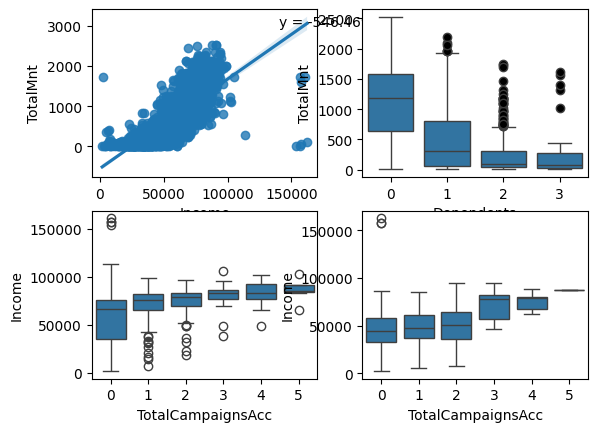

In [4]:
'''based on heatmap:
1. income actually has a positive correlation to purchases (any)
2. number of dependents has a positive correlation to number of deal purchases and visits, but negative towards all other purchases
3. Campaigns are quite correlated to each other'''
#finding more correlation using bivariate or univariate analysis
plt.subplot(2,2,1)
#1. doing regplot for comparison of income with purchases
p1 = sns.regplot(x = 'Income', y = 'TotalMnt', data = ifood[ifood['Income'] < 200000])
slope, intercept, r, p, sterr = scipy.stats.linregress(x = p1.get_lines()[0].get_xdata(), y = p1.get_lines()[0].get_ydata())
plt.text(140000, 3000, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')

plt.subplot(2,2,2)
#2. doing multiple boxplot for comparison of dependents on expenditure
plot2 = sns.boxplot(x = 'Dependents', y = 'TotalMnt', data = ifood, flierprops = {'marker': 'o', 'markerfacecolor': 'black'})


#3. having kids and teens on campaign acceptance
plt.subplot(2,2,3)
plot3 = sns.boxplot(x = 'TotalCampaignsAcc', y = 'Income', data = ifood[(ifood['Income'] < 200000) & (ifood['Dependents'] == 0)])

plt.subplot(2,2,4)
plot4 = sns.boxplot(x = 'TotalCampaignsAcc', y = 'Income', data = ifood[(ifood['Income'] < 200000) & (ifood['Dependents'] > 0)])

In [5]:
ifood_train_test = ifood.drop(columns = ['ID', 'Z_CostContact', 'Z_Revenue', 'Country']).select_dtypes(np.number)
purchases = [col for col in ifood if 'Purchases' in col] + ['Year_Customer']

In [6]:
linear = linear_model.LinearRegression()
X = ifood_train_test.drop(columns = 'NumStorePurchases')
#X = ifood_train_test.loc[:,purchases]
y = ifood_train_test['NumStorePurchases']
#just using a minmaxscaler for normalization and normalization
scaler = preprocessing.StandardScaler()
X_scale = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scale, y, test_size= 0.3, random_state= 1)
reg = linear.fit(X_train, y_train)
y_pred = reg.predict(X_test)
metric = metrics.mean_squared_error(y_test, y_pred)
metric_sqrt = np.sqrt(metric)
scores = reg.score(X_test, y_test)
print(metric_sqrt, scores)

#using permutation feature importance? What it means:
''' Model inspection technique that measure contribution of each feature to a fitted model - useful for non-linear or opaque estimators'''
'''this is done by comparing your target variable (Y) with multiple independent variables,
then calculating increase of the model's prediction error (or decrease) through multiple combinations of testing with varying number of estimator variables'''
result = inspection.permutation_importance(reg, X_test, y_test, n_repeats = 10, random_state = 1)

features = pd.DataFrame({'Feature_Name':[], 'Error_Mean':[], 'Error_std': []})

for i in range(len(result.importances_mean)):
    features.loc[len(features)] = [X.columns[i], result.importances_mean[i], result.importances_std[i]]

print(features.sort_values(by = 'Error_Mean', ascending = False))

'''for i in range(len(result.importances_mean)):
    print(f"{correlation.columns[i]:<8}" + ' '
              f"{result.importances_mean[i]:.3f}"
              f" +/- {result.importances_std[i]:.3f}")'''

#result: most important features are purchases and purchases counts.

1.2220412713993727e-14 1.0
           Feature_Name  Error_Mean     Error_std
26       TotalPurchases   12.172098  2.350877e-01
15  NumCatalogPurchases    1.872203  4.482350e-02
14      NumWebPurchases    1.393967  4.682395e-02
13    NumDealsPurchases    0.721036  2.813161e-02
24           Dependents    0.009889  3.952002e-04
5              Teenhome    0.005252  1.839374e-04
4               Kidhome    0.005212  1.939478e-04
27             TotalMnt    0.003422  4.436267e-05
7              MntWines    0.001040  3.525288e-05
9       MntMeatProducts    0.000465  8.669309e-06
28    TotalCampaignsAcc    0.000057  1.122234e-06
10      MntFishProducts    0.000027  5.941947e-07
12         MntGoldProds    0.000023  1.110862e-06
11     MntSweetProducts    0.000017  4.840551e-07
8             MntFruits    0.000012  5.656288e-07
23             Response    0.000009  3.128970e-07
18         AcceptedCmp4    0.000005  1.933436e-07
17         AcceptedCmp3    0.000005  2.164218e-07
19         AcceptedCmp5

'for i in range(len(result.importances_mean)):\n    print(f"{correlation.columns[i]:<8}" + \' \'\n              f"{result.importances_mean[i]:.3f}"\n              f" +/- {result.importances_std[i]:.3f}")'

In [7]:
#doing a SHAP/Lime plot for absolute differences (to find relative signs - increase or decrease)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names = X.columns,
                                                   class_names = ['MEDV'], verbose = True, mode = 'regression')
#print(X_train, X_test)
#exp = explainer.explain_instance(X_test.values[5], y_pred, num_features = 5)
#exp.show_in_notebook(show_table = True)

In [8]:
#US faring significantly in terms of store purchases - just use barplot with country hue
'''to do after i do all the rest'''

'to do after i do all the rest'

In [ ]:
#Is it true that people who buy gold are more conservative? I.e. last 2 years of increased gold purchases = increase num of store purchases?
print(ifood['MntGoldProds'].describe())
ifood_last_2_years = ifood[(ifood['Year_Customer'] >= 2012)]
#use chi-square statistic to check if there is a relationship. Assume non linearity or normal because of its ordinal nature
#need to check if gold product purchases increase = num store purchases increase
chi_sq_stat, p_value = scipy.stats.kendalltau(ifood_last_2_years['MntGoldProds'], ifood_last_2_years['NumStorePurchases'], alternative= 'two-sided')
print(chi_sq_stat, p_value)

In [ ]:
#Do Married PHD candidates have increased spending on fish as compared to the general population?
'''thought process - group them based on r/s status, as well as education status, and see if they have a greater proportion'''
ifood_origin['PHD_or_not'] = ['PhD' if i == 'PhD' else 'Not_PhD' for i in ifood_origin['Education']]
print(ifood_origin['Education'].unique)
ifood_origin['Married_or_not'] = ['Married' if i == 'Married' else 'Not_Married' for i in ifood_origin['Marital_Status']]
ifood_origin['Married_PHD'] = ifood_origin['PHD_or_not'] + ' ' + ifood_origin['Married_or_not']
ifood_origin['Married_PHD'] = ['Married_PHD' if i == 'PhD Married' else 'nope' for i in ifood_origin['Married_PHD']]
sns.boxplot(x = ifood_origin['Married_PHD'], y = ifood_origin['MntFishProducts'], color = 'b')

#do t test to check for randomness between samples of the variable
scipy.stats.ttest_ind(ifood_origin[ifood_origin['Married_PHD'] == 'Married_PHD']['MntFishProducts'], ifood_origin[ifood_origin['Married_PHD'] == 'nope']['MntFishProducts']).pvalue

In [ ]:
#what factors are significantly related to fish amount spendings?
'''same as factors on purchases, use heatmap or clustermap to find relationship and regression methods.'''
'''I want to do later hahahha'''

In [ ]:
#is there a sig r/s between geographical regions and success of a campaign.
'''To do: find out based on a barplot on the campaign scores grouped by regions'''
'''Note: can do addition of all values, or just filter LOL based on each campaign'''
